In [1]:
import torch
import torch.nn as nn

from torch import optim
import torchvision.datasets as dataset
import torchvision.transforms as transforms
from utils.CvTransform import CvResize, CvCenterCrop

import torch.utils.data

from utils.tokenMaker import Lang
from utils.tool import padding, flatMutileLength, fixString
from model.BigModel import SubImgToSeq, SubVideoToSeq
from dataset.readVideo import DramaDataset
useCuda = True
device = torch.device("cuda" if useCuda else "cpu")

In [2]:
DataDir="/home/ball/Videos/BrokeEN"
datasets = DramaDataset(basedir=DataDir,
                        maxFrame=1,
                        timeOffset=0.2,
                        useBmp=True
                        )
transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                ])
len(datasets)

Total Drama: 113


39335

In [3]:
import random
def getSample(size):
    imgs = []
    pres = []
    nexs = []
    for i in range(size):
        pre, nex, img = random.choice(datasets)
        imgs.append(img)
        pres.append(pre)
        nexs.append(nex)
    return pres, nexs, imgs

In [4]:
def predit(model, lang, imgs, subtitle, max_length=50):
    ans = []
    probs = []
    inputImgs = imgs.unsqueeze(0).to(device)
    subtitle = torch.LongTensor(lang.sentenceToVector(subtitle, sos=False, eos=False)).unsqueeze(0).to(device)
    inputs = torch.LongTensor([[lang["SOS"]]]).long().to(device)
    
    hidden = None
    
    cxt = model.makeContext(inputImgs, subtitle)
    for i in range(max_length):
        outputs, hidden = model.decode(inputs, cxt, hidden)
        prob, outputs = outputs.topk(1)
        probs.append(prob.item())

        if(outputs.item() == lang["EOS"]):
            break
        ans.append(outputs.item())

        inputs = outputs.squeeze(1).detach()
    return lang.vectorToSentence(ans), probs

def mutilePredit(pres, nexs, imgs):
    makes = []
    for pre, nex, img in zip(pres, nexs, imgs):
        mk = predit(model, lang, transform(img[0]).unsqueeze(0), pre)
        makes.append(mk[0])
    return makes

def toBatchFirst(outputs):
    nep = len(outputs)
    nbatch = len(outputs[0])
    bFirst = []
    for b in range(nbatch):
        bdatas = []
        for e in range(nep):
            bdatas.append(outputs[e][b])
        bFirst.append(bdatas)
    return bFirst

In [5]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
toPIL = transforms.ToPILImage()

def showImgs(imgs, preSubs, targets, labels):
    col=1
    plt.figure(figsize=(20,50))
    for i in range(len(imgs)):
        plt.subplot(len(imgs)/col+1,col,i+1)
        plt.axis('off')
        plt.imshow(imgs[i])
        plt.title("Pre: {}\nNext: {}\nPredit: {}".format(preSubs[i], targets[i], labels[i]), fontsize=20)
    plt.show()
def showVar(data):
    x = range(0, data.size(-1))
    plt.bar(x, data.data.cpu())
    plt.show()
def showValue(data):
    x = range(0, len(data))
    plt.plot(x, data)
    plt.show()

In [6]:
import pickle
import os
ModelDir = "ImgSub2Sub/models/bken_fix_rnn"
with open(os.path.join(ModelDir, "Lang.pkl"), 'rb') as f:
    lang = pickle.load(f)
    print("Load lang model: {}. Word size: {}".format(ModelDir, len(lang)))
model = torch.load(os.path.join(ModelDir, "SubImgModel.14.pth")).to(device).eval()

Load lang model: ImgSub2Sub/models/bken_fix_rnn. Word size: 15479


In [7]:
pres, nexs, imgs = getSample(5)

In [12]:
ppres, pnexs, pimgs = pres, nexs, imgs
ppres = [ppres[0]]*len(ppres)
# pimgs = [pimgs[0]]*len(pimgs)
makes = mutilePredit(ppres, pnexs, pimgs)

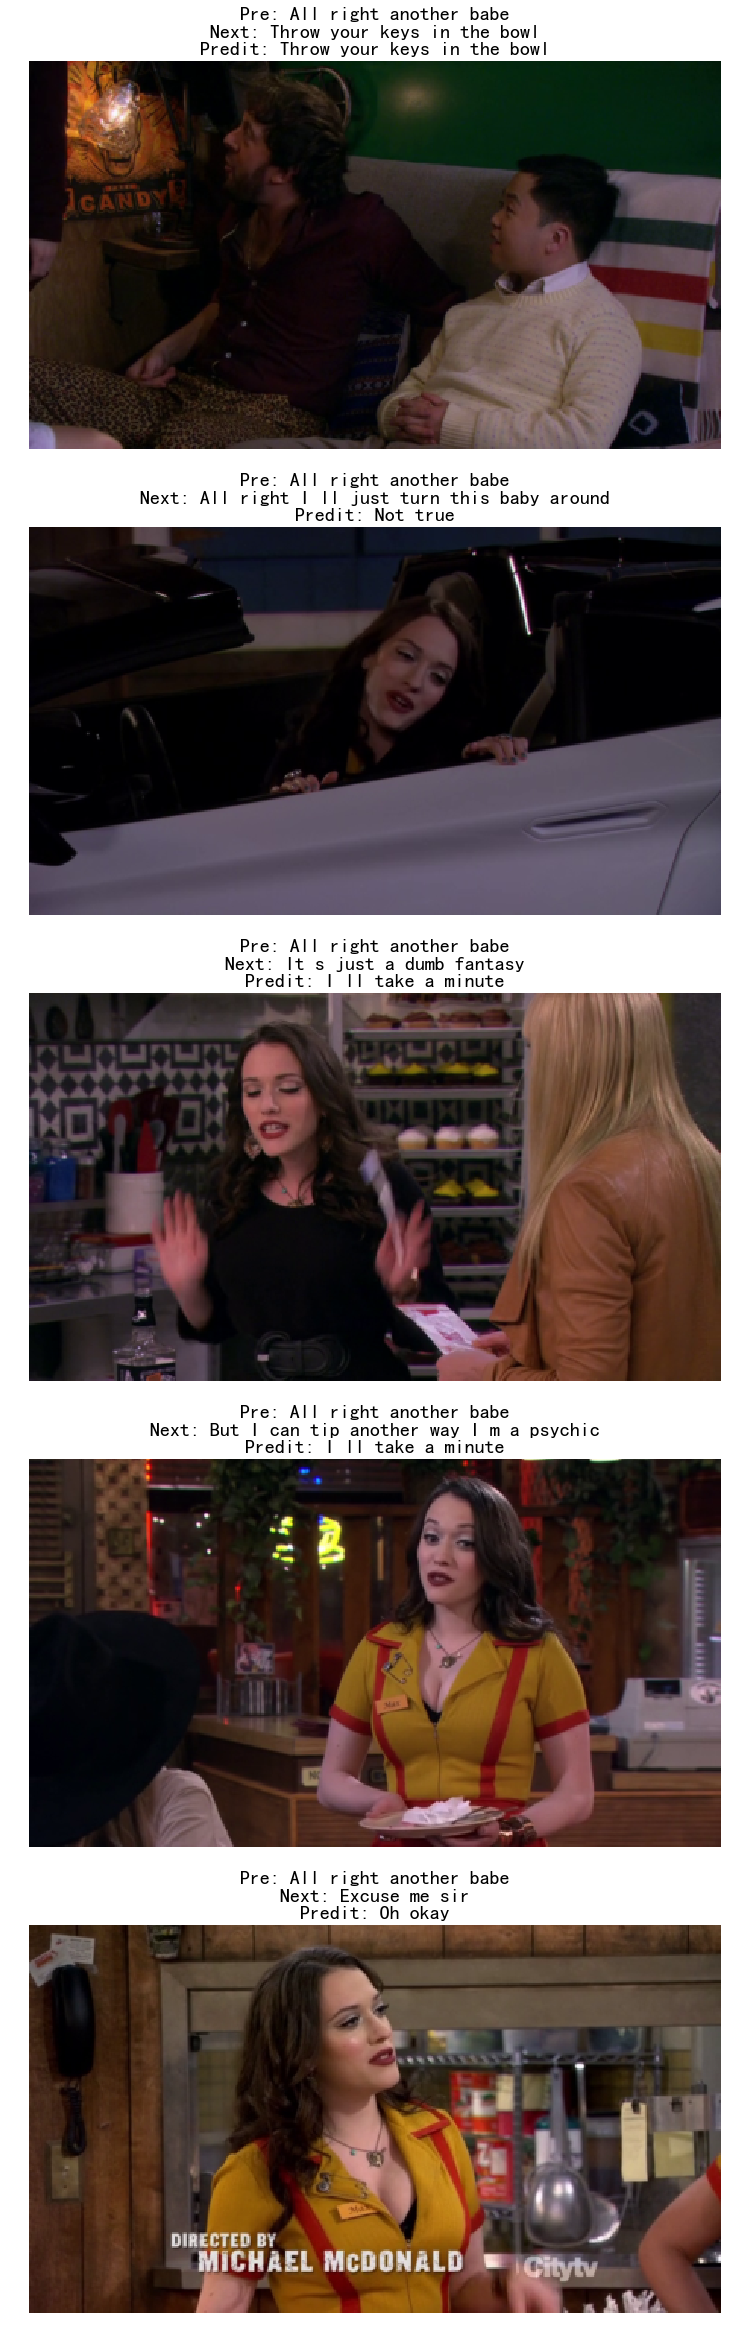

In [13]:
showImgs([ims[0] for ims in pimgs], ppres, pnexs, makes)

In [22]:
import pandas as pd
result = pd.DataFrame([], columns=["pre", "next", "make"])
for _ in range(10):
    pres, nexs, imgs = getSample(64)
    makes = mutilePredit(pres, nexs, imgs)
    parts = pd.DataFrame([], columns=["pre", "next"])
    parts["pre"] = pres
    parts["next"] = nexs
    parts["make"] = makes
    result = result.append(parts,ignore_index=True)

In [23]:
result.to_json("result_rnn.json")

In [15]:
def getEncoder(modal, sub):
    subVar =  torch.LongTensor(lang.sentenceToVector(sub, sos=False, eos=False)).to(device).unsqueeze(0)
    return modal.subRnn(subVar)[0][:,-1,:]
cos = nn.CosineSimilarity(dim=1)

In [16]:
pres, nexs, imgs = getSample(64)

In [17]:
epcoss = []
outputs = []
for i in range(1, 14):
    model = torch.load(os.path.join(ModelDir, "SubImgModel.{}.pth".format(i))).eval()
    makes = mutilePredit(pres, nexs, imgs)
    tars = torch.cat([getEncoder(model, nex) for nex in nexs], dim=0)
    preds = torch.cat([getEncoder(model, pred) for pred in makes], dim=0)
    cs = cos(tars, preds)
    epcoss.append(cs.mean().item())
    outputs.append(makes)
    print("Mean: {:.4f}, Max: {:.4f}, Min: {:.4f}".format(cs.mean().item(),
                                             cs.max().item(),
                                             cs.min().item()))
bfOutputs = toBatchFirst(outputs)

Mean: 0.0596, Max: 0.3639, Min: -0.2006
Mean: 0.0780, Max: 0.7870, Min: -0.2223
Mean: 0.1107, Max: 1.0000, Min: -0.1614
Mean: 0.0820, Max: 1.0000, Min: -0.1892
Mean: 0.1353, Max: 1.0000, Min: -0.1194
Mean: 0.1285, Max: 1.0000, Min: -0.2591
Mean: 0.1671, Max: 1.0000, Min: -0.1714
Mean: 0.1465, Max: 1.0000, Min: -0.1733
Mean: 0.1726, Max: 1.0000, Min: -0.1109
Mean: 0.2068, Max: 1.0000, Min: -0.1771
Mean: 0.3265, Max: 1.0000, Min: -0.1128
Mean: 0.3418, Max: 1.0000, Min: -0.1240
Mean: 0.4105, Max: 1.0000, Min: -0.0972


In [20]:
coss = []
for makes in outputs:
    tars = torch.cat([getEncoder(model, nex) for nex in nexs], dim=0)
    preds = torch.cat([getEncoder(model, pred) for pred in makes], dim=0)
    cs = cos(tars, preds)
    coss.append(cs.mean().item())
    print("Mean: {:.4f}, Max: {:.4f}, Min: {:.4f}, Equal: {}".format(cs.mean().item(),
                                                         cs.max().item(),
                                                         cs.min().item(),
                                                         (cs>=0.9).float().sum().item()))

Mean: 0.0297, Max: 0.3544, Min: -0.1887, Equal: 0.0
Mean: 0.0513, Max: 0.7370, Min: -0.1987, Equal: 0.0
Mean: 0.0942, Max: 1.0000, Min: -0.1846, Equal: 1.0
Mean: 0.0874, Max: 1.0000, Min: -0.1861, Equal: 1.0
Mean: 0.1137, Max: 1.0000, Min: -0.1429, Equal: 1.0
Mean: 0.1198, Max: 1.0000, Min: -0.2460, Equal: 2.0
Mean: 0.1641, Max: 1.0000, Min: -0.1455, Equal: 5.0
Mean: 0.1392, Max: 1.0000, Min: -0.1332, Equal: 3.0
Mean: 0.1650, Max: 1.0000, Min: -0.1078, Equal: 3.0
Mean: 0.2017, Max: 1.0000, Min: -0.2042, Equal: 8.0
Mean: 0.3285, Max: 1.0000, Min: -0.0869, Equal: 16.0
Mean: 0.3431, Max: 1.0000, Min: -0.1278, Equal: 18.0
Mean: 0.4105, Max: 1.0000, Min: -0.0972, Equal: 22.0


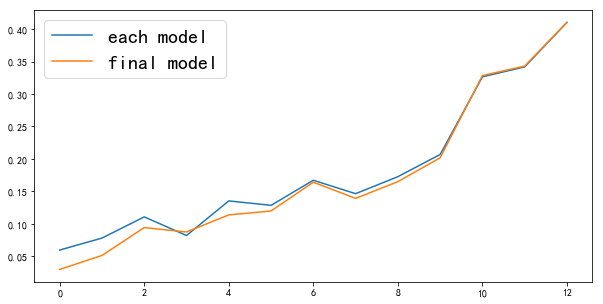

In [21]:
x = range(0, len(coss))
plt.figure(figsize=(10,5))
plt.plot(x, epcoss, label="each model")
plt.plot(x, coss, label="final model")

plt.legend(fontsize=20)
plt.show()

Pre: Nothing
Next: I mean who in the hell would order popovers And not hide a diamond ring in it

I m not gonna go to the diner
I m not gonna go out of here
I know I m gonna go down there and I m not gonna do it
I m gonna go get some pricks out of here
I mean if we re gonna do it up in a few kitchens and then we ll get up some shifts
I m gonna be happy to get up some of these two girls in the diner
I m not gonna be happy for this but I m not gonna be fri up some of those escape rooms
I m gonna be happy to see me in an hour
It s a really good deal Max
I know what s going on in there
I m not gonna be happy one for a few minutes till she put herself on a stoop
I can t believe we re gonna find another one before
I know what I did not think she would be happy in a few kitchens and then she met her in a dumpster


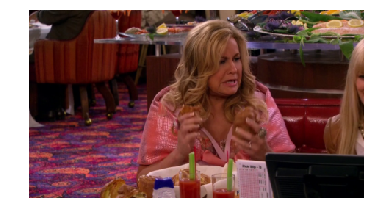

In [44]:
i = 25
print("Pre: {}".format(pres[i]))
print("Next: {}\n".format(nexs[i]))
print("\n".join(bfOutputs[i]))
plt.axis('off')
plt.imshow(imgs[i][0])
plt.show()